Во всех задания требуется написать эффективные реализации, используя функционал numpy. Использовать numba, вызывать код из C или использовать посторонние библиотеки запрещается. В заданиях указаны ориентировочные времена работы. Они могут отличаться на разных машинах, поэтому на вашем компьютере правильное решение может работать как быстрее, так и медленнее. Если в задании указано, что время работы 8 мин, а у вас работает 10, скорее всего, это не страшно. Если же указано 8 мин, а код работает 8 часов, это вряд ли можно списать на медленный компьютер.

# 1. Перебор параметров по сетке

Пусть задана функция вида $$ f(x) = \dfrac{d \log^a{(x)}}{1 + x^b e^{\frac{-c}{x}}} $$
Требуется восстановиться параметры $a, b, c$ и $d$ по значениям функции в узлах заданной сетки. Для этого:
1. Выберете некоторые значения $a, b, c$ и $d$. Например, $a=1.2$, $b=0.4$, $c=1.5$, $d=1.0$;
2. Сгенерируйте сетку, на которой будут вычисляться значение функции. Сетка должна содержать $1,000$ узлов. Например, хорошо подойдет равномерная сетка на отрезке $[1, 100]$ с $1,000$ узлов;
3. Вычислите значения $f(x)$ в узлах сгенерированной сетки;
4. Далее требуется восстановить величины $a, b, c$ и $d$ по значениям $f(x)$ в узлах сгенерированной сетки. Для этого сгенерируйте возможные наборы значений для параметров $a, b, c$ и $d$. Для каждого из параметров должно быть 100 (или 101, если удобнее) значений. Например, для приведенных выше значений хорошо подойдут равномерные сетки на отрезках $[1, 2]$, $[0, 1]$, $[1, 2]$ и $[0, 2]$ соответственно с 101 узлом каждая. Всего имеем $101^4$ комбинаций параметров. Требуется, перебирая всевозможные наборы параметров и вычисления значения функции в узлах сетки, найти те значения, которые будут обеспечивать минимум $l_2$ нормы разности правильного и построенного набора значений.

Ориентировочное время работы при правильной организации перебора $-$ 8 мин.

P.S. В задании требуется просто разумно реализовать перебор на numpy. Придумывать правильный алгоритм перебора, отсечения или как-либо еще "по-умному" производить оптимизацию не требуется.

In [314]:
import numpy as np

a_0 = 1.2
b_0 = 0.4
c_0 = 1.5
d_0 = 1.0

def Znamen(x, b, c):
    res = (np.exp(-c / x)).reshape(101, 1, 1000)
    res = 1 / (1 + (grid ** b) * res)
    return res

def Chisl(x, a, d):
    res = d * (np.log(x) ** a)
    return res

In [315]:
# равномерная сетка на отрезке [1,100] c 1000 узлов
grid = np.linspace(1, 100, 1000).reshape(1, 1000)

a = np.linspace(1, 2, 101)
b = np.linspace(0, 1, 101)
c = np.linspace(1, 2, 101)
d = np.linspace(0, 2, 101)
A = Znamen(grid, b.reshape(101, 1), c.reshape(101, 1))

b0 = np.full((101, 1), b_0)
c0 = np.full((101, 1), c_0)
A0 = Znamen(grid, b0, c0)

In [316]:
%%time

a_min = 0
d_min = 0
argmin = 0
Min = np.inf

for i in range(len(a)):
    for j in range(len(d)):
        diff = (Chisl(grid, a[i], d[j]) * A) - (Chisl(grid, a_0, d_0) * A0)
        norm = np.linalg.norm(diff, axis=2)
        if Min > np.min(norm):
            Min = np.min(norm)
            a_min = a[i]
            d_min = d[j]
            argmin = np.argmin(norm)
c_b_min = np.unravel_index(argmin, (101, 101))

print('Восстановленные величины:')
print('a = ', a_min)
print('b = ', b[c_b_min[1]])
print('c = ', c[c_b_min[0]])
print('d = ', d_min)

Восстановленные величины:
a =  1.2
b =  0.4
c =  1.5
d =  1.0
CPU times: user 11min 11s, sys: 3min 32s, total: 14min 43s
Wall time: 14min 45s


# 2. Преобразования тензоров

1. Сгенерируйте случайный тензор (случайный numpy.array) размера $\underbrace{2 \times 2 \times \dots \times 2}_\text{16 раз}$.
2. Последовательно произведите с ним следующую процедуру. Разбейте множители на пары: $$ (2 \times 2) \times (2 \times 2) $$ и вычислите кронекерово произведение векторов в скобках. Повторяйте процедуру пока не останется один вектор. $$ 2 \times 2 \times 2 \times 2 \to (2 \times 2) \times (2 \times 2) \to 4 \times 4 \to (4 \times 4) \to 16 $$ В результате должен получиться вектор длины $2^{16}$.
3. Из построенного вектора попробуйте восстановить исходное представление. А именно, пусть имеется вектор длины $16$. С помощью reshape его можно преобразовать к матрице $4 \times 4$. Для матрицы $4 \times 4$ постройте оптимальное одноранговое приближение - это будет произведение двух векторов размера 4. Для каждого из векторов длины 4 повторите операцию.
$$ 16 \to 4 \times 4 \to (2 \times 2) \times (2 \times 2) \to 2 \times 2 \times 2 \times 2 $$

Схема метода:
<img src="Tensor2-1.png" width="500"/>
<img src="Tensor3-1.png" width="500"/>

(На самом деле это схема для чуть более сложного варианта, значок суммы можно игнорировать)

In [317]:
import numpy as np

def Divide(row):
    if row.size == 2:
        return row
    n = np.int64(np.sqrt(len(row)))
    u, s, v = np.linalg.svd(row.reshape((n, n)))
    return np.vstack((Divide(u[:, 0] * s[0]), Divide(v[0, :])))

In [324]:
old_tensor = np.random.rand(16, 2)

In [325]:
tensor = old_tensor.copy()
chet_ind = np.arange(0, 16, 2)
nechet_ind = np.arange(1, 16, 2)
for i in 8, 4, 2:
    array = np.kron(tensor[chet_ind][0], tensor[nechet_ind][0])
    for j in range(1, i):
        array = np.vstack((array, np.kron(tensor[chet_ind][j], tensor[nechet_ind][j])))
    tensor = array
    print(tensor.shape)
    chet_ind = np.arange(0, i, 2)
    nechet_ind = np.arange(1, i, 2)
res = np.kron(tensor[0], tensor[1])   
print(res.shape)

(8, 4)
(4, 16)
(2, 256)
(65536,)


In [326]:
t1 = np.einsum('a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p->abcdefghijklmnop', *Divide(res).tolist())
t2 = np.einsum('a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p->abcdefghijklmnop', *old_tensor.tolist())
print(np.max(t2.reshape(-1) - res))
print(np.max(np.abs(t1 - t2)))

1.0842021724855044e-19
3.2526065174565133e-19


# 3. Метрика кластеризации

(Задание честно своровано из задач весеннего семестра по курсу машинного обучения)

Требуется реализовать одну из классических метрик для оценки качества кластеризации. Задача кластеризации $-$ это, грубо говоря, задача разбить набор данных на классы похожих. В данном случае объектами будут вектора из $\mathbb{R}^d$, а мерой похожести евклидово расстояние.
<img src="clustering_intro_clustersamplegraph.jpg" width="500"/>

Требуется эффективно реализовать метрику силуэт для оценки качества кластеризации. Для этого необходимо реализовать функцию, которая принимает numpy.array размера $n \times d$, а также список меток размера $n$, где $n$ $-$ число элементов, а $d$ $-$ размерность пространства. Функция должна возвращать одно число $-$ значение метрики.

Суть метрики заключается в оценке двух параметров, характеризующих выделенные кластеры — компактность и отделимость.

Положим, что $C_i$ — номер кластера для объекта $i$.

$s_i$ — компактность кластеризации объекта $i$ определяется как среднее расстояние от него до всех объектов
того же кластера:
$$ s_i = \dfrac{1}{|\{j: C_j = C_i\}| - 1} \sum\limits_{j: C_j=C_i} \|x_i - x_j\| $$

$d_i$ — отделимость кластеризации объекта $i$ определяется как среднее расстояние от него до всех объектов
второго по близости кластера:
$$ \min\limits_{C:C\neq C_i} \dfrac{1}{|\{ j: C_j = C \}|} \sum\limits_{j: C_j=C} \|x_i - x_j\| $$

Тогда силуэт объекта i:
$$ \text{sil}_i = \dfrac{d_i - s_i}{\max{\{d_i, s_i\}}} $$

И, наконец, коэффициент силуэта для выборки определяется как среднее силуэтов объектов:
$$ S = \dfrac{1}{n} \sum\limits_{i} \text{sil}_i $$

На следующем тесте
```
data, labels = np.array([[0.0, 0.0], [0.0, 1.0], [1.0, 0.0], [2.0, 2.0]]),
               np.array([1, 0, 0, 1])
```
Результатом является `-0.15098532303997897`.

На тесте
```
np.random.seed(1568)
data = np.random.randn(5000, 1200)
labels = np.random.randint(low=0, high=100, size=data.shape[0])
```
Результат работы равен `-0.006423534504746837`, а время работы составляет порядка 0.6с.

Ваша реализация должна удовлетворять следующим требованиям:
1. При вычислении не должно возникать warning, бесконечностей и nan-ов
2. Используйте не более одного цикла
3. Учтите, что метки кластеров могут идти не по порядку и принимать произвольные значения
4. Если в данных присутствует один кластер, то считайте что силуэт равен 0
5. Если $s_i = d_i = 0$, то $\text{sil}_i = 0$

In [327]:
import numpy as np
import time

def Sil(data, labels):
    s = np.zeros(len(labels))
    d = np.full(len(labels), np.inf)
    
    tmp = np.sum(data * data, axis=1).reshape((len(data), 1))
    Sum = np.sum(data * data, axis=1) + tmp
    norm = Sum - 2 * np.dot(data, data.T)
    #norm = np.where(norm < 0, 0, np.sqrt(norm)) - почему тут был ворнинг?((
    norm[norm < 0] = 0
    norm = np.sqrt(norm)
    #print (norm)
    lab_uniq = np.unique(labels)
    #print(lab_uniq)
    #print(labels)
    for i in range(len(lab_uniq)):
        eq = labels == lab_uniq[i]
        #print(eq)
        matrix = norm[:, eq]
        s[eq] = np.sum(matrix[eq], axis=1) / (np.sum(eq) - 1)
        summ = np.sum(matrix, axis=1) / np.sum(eq)
        summ[eq] = np.inf
        d[summ < d] = summ[summ < d]
    arr = np.zeros(len(labels))
    arr[d > s] = d[d > s]
    arr[(d <= s)] = s[(d <= s)]
    return (np.sum((d - s) / arr) / len(labels))

In [328]:
data, labels = np.array([[0.0, 0.0], [0.0, 1.0], [1.0, 0.0], [2.0, 2.0]]), np.array([1, 0, 0, 1])
Sil(data, labels)

-0.15098532303997897

In [329]:
%%timeit
np.random.seed(1568)
data = np.random.randn(5000, 1200)
labels = np.random.randint(low=0, high=100, size=data.shape[0])

Sil(data, labels)

1.46 s ± 58 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# 4. Монотонная нелинейная функция

Рассмотрим произвольную монотонную непрерывную на отрезке $[-T, T]$ функцию $f(x)$. Ее можно приблизить кусочно-линейной непрерывной функцией $g(x)$ следующим образом. Построим равномерную сетку
$$ x_0=-T, x_1, x_2, \dots, x_{K-2}, x_{K-1} = T $$
на отрезке $[-T, T]$ с $K$ узлами. Пусть $g(-T) = b_0$ и $g(x)$ линейна на отрезках $[x_{i-1}, x_i]$. Поскольку $g(x)$ непрерывна, она однозначно задается значениями $b_0$ и коэффицентами наклона $\alpha_i$. Действительно,
$$ g(x_0) = b_0 $$
$$ g(x_i) = g(x_{i-1}) + \alpha_{i-1} (x_i - x_{i-1}), ~~ i=1,\dots,K-1 $$

При этом на практике неотрицательные углы наклона часто удобно параметризовать как
$$ \alpha_i = \log(1 + e^{v_i}) $$

Пусть задано значение $b_0$ и набор $v_i$, $i=0, 1, \dots, K-2$. Пусть также задан тензор $X$ значений $x_j$ произвольного размера. Гарантируется, что $-T \le x_j \le T$. Необходимо реализовать функцию, которая бы поэлементно вычисляла значения $g(X)$ (как это делают универсальные функции в numpy). Реализация не должна использовать циклов и сторонних библиотек, в том числе numba, `@vectorize` и прочее.

Для демонстрации правильности работы визуализируйте график функции с помощью matplotlib для нескольких разумных частных случаев.

Ориентировочное время работы для тензора $500 \times 500 \times 500$ и $K=1000$ равно 4.5с на 1 ядре.

In [330]:
import numpy as np
import matplotlib.pyplot as plt

def func(X, b0, v, node, k):
    alpha = np.log(1 + np.exp(v))
    g = np.zeros(k)
    g = alpha * np.diff(node)
    g = np.insert(g, 0, b0)
    g = np.cumsum(g)
    ind = np.searchsorted(node, np.ravel(X), side='right') - 1
    ind[ind >= k - 1] -= 1
    g = g[ind] + alpha[ind] * (np.ravel(X) - node[ind])
    g = np.reshape(g, X.shape)
    return g

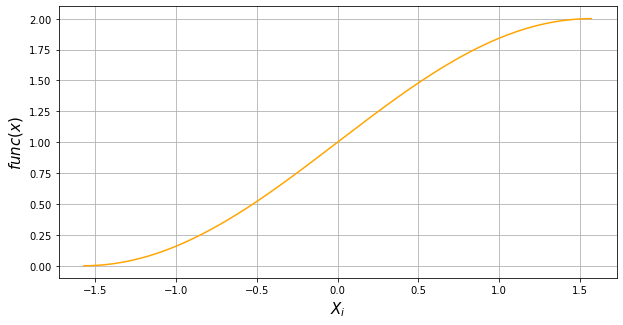

In [331]:
K = 1000
T = np.pi / 2
b0 = 0

X = np.linspace(-T, T, K + 1)
v = (np.sin(X[1:]) - np.sin(X[:-1])) / (X[1:] - X[:-1])
v = np.log(np.exp(v) - 1)

plt.figure(figsize = (10,5))
plt.plot(new_X, func(np.linspace(-T, T, 10 * K), b0, v, X, K), color = 'orange')
plt.xlabel('$X_i$', size = 15)
plt.ylabel('$func(x)$', size = 15)
plt.grid()